# Chapter 4

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import pystan
import arviz

SEED = 1234
np.random.seed(SEED)
sns.set()

## 4.4.2

In [2]:
data_salary = pd.read_csv('../data/salary.csv')

In [3]:
data_salary.head()

,x,y
0,24,472
1,24,403
2,26,454
3,32,575
4,33,546


<AxesSubplot:xlabel='x', ylabel='y'>

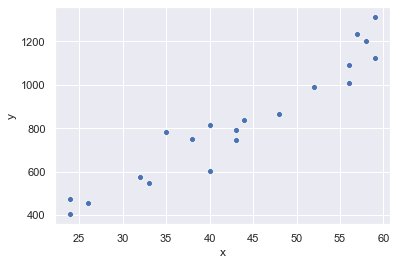

In [4]:
sns.scatterplot(x='x', y='y', data=data_salary)

## 4.4.5

In [5]:
!cat ../model/main-5.stan

data {
  int N;
  real x[N];
  real y[N];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

model {
  for (n in 1:N) {
    y[n] ~ normal(a + b * x[n], sigma);
  }
}


## 4.4.6

In [6]:
model = pystan.StanModel(file='../model/main-5.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d93e57f29a42d65bafcb6dea872843a4 NOW.


In [7]:
data_salary_dict = data_salary.to_dict('list')
data_salary_dict['N'] = len(data_salary)

## 4.4.7

In [8]:
fit = model.sampling(data_salary_dict, seed=SEED, n_jobs=1)

In [9]:
fit

Inference for Stan model: anon_model_d93e57f29a42d65bafcb6dea872843a4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     -122.1    2.32  76.05 -277.1 -171.1 -121.3 -72.33  25.91   1079    1.0
b      21.97    0.05    1.7  18.63  20.84  21.95  23.03  25.41   1055    1.0
sigma  85.38    0.46  15.97   61.1  74.03  83.61   93.7 121.65   1185    1.0
lp__  -93.67    0.04   1.37 -97.08 -94.27 -93.33 -92.71 -92.17    942   1.01

Samples were drawn using NUTS at Thu Aug 27 23:10:33 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

## 4.4.8

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

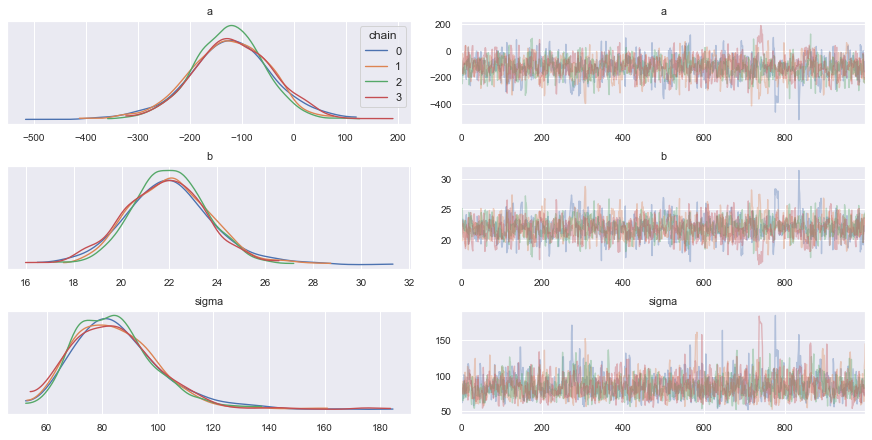

In [10]:
arviz.plot_trace(fit, legend=True)

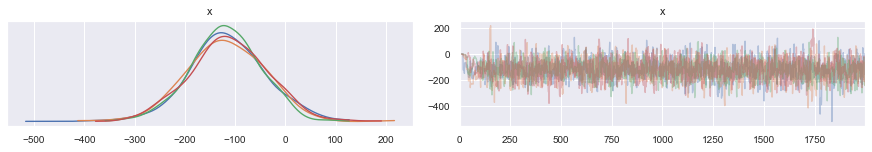

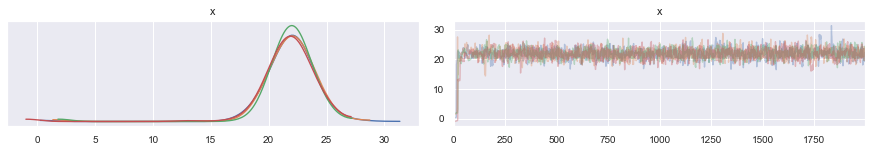

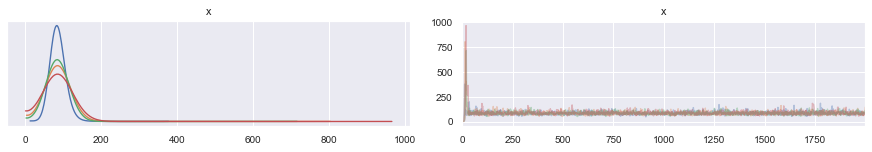

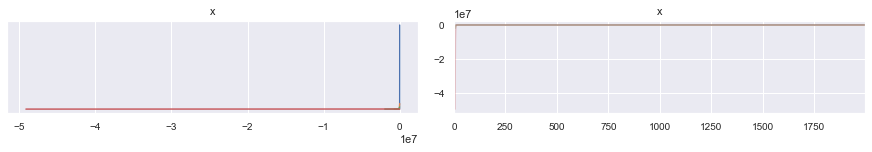

In [11]:
for _ in range(4):
    arviz.plot_trace(fit.extract(permuted=False, inc_warmup=True)[:,:,_].T)

array([[<AxesSubplot:ylabel='a'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='b'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='a', ylabel='sigma'>,
        <AxesSubplot:xlabel='b'>, <AxesSubplot:xlabel='sigma'>]],
      dtype=object)

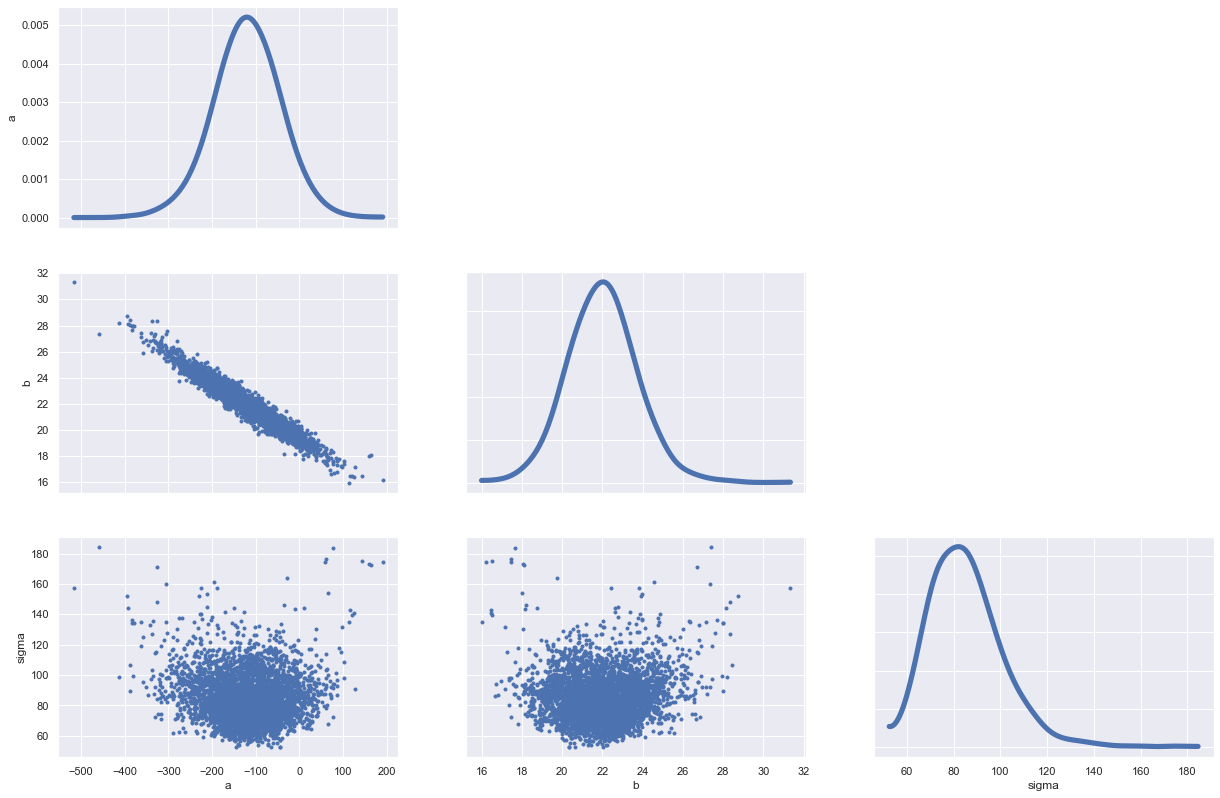

In [12]:
arviz.plot_pair(fit, marginals=True)

## 4.4.11

In [13]:
sample_df = fit.to_dataframe()

In [14]:
sample_df[['a', 'b', 'sigma', 'lp__']].quantile(q=[.025, .975])

,a,b,sigma,lp__
0.025,-277.038933,18.634481,61.125193,-97.074691
0.975,25.891440,25.400914,121.615627,-92.168639


In [15]:
y_50_base = sample_df['a'] + sample_df['b'] * 50
y_50 = np.random.normal(y_50_base, sample_df['sigma'])
y_50_df = sample_df[['a', 'b', 'sigma']].join(pd.DataFrame({'y_50_base': y_50_base, 'y_50': y_50}))
y_50_df

,a,b,sigma,y_50_base,y_50
0,-169.053446,22.861463,97.675821,974.019698,1020.067515
1,-70.921786,20.910481,75.676669,974.602252,884.473179
2,-162.781168,22.795638,61.959025,977.000717,1065.769844
3,-152.744241,22.297159,72.342814,962.113705,939.495587
4,-185.284672,23.394143,82.741570,984.422499,924.799856
...,...,...,...,...,...
3995,-34.590239,19.942986,87.103907,962.559077,987.240222
3996,-195.122043,23.632845,75.205659,986.520191,977.427725
3997,-212.264413,23.330511,71.451304,954.261137,1004.491185
3998,-179.604054,23.118095,73.278758,976.300704,952.954183


In [16]:
y_50_df.quantile(q=[.025, .25, .5, .75, .975])

,a,b,sigma,y_50_base,y_50
0.025,-277.038933,18.634481,61.125193,932.783075,807.836273
0.250,-171.127912,20.835756,74.033665,961.108156,923.115566
0.500,-121.392962,21.953224,83.605389,975.784835,977.823990
0.750,-72.345655,23.032429,93.702331,991.088139,1034.325802
0.975,25.891440,25.400914,121.615627,1021.094123,1155.758345


In [17]:
x_new = range(23, 61)
y_n_base_dict = {}
y_n_pred_dict = {}

for x_n in x_new:
    y_n_base_dict[x_n] = sample_df['a'] + sample_df['b'] * x_n
    y_n_pred_dict[x_n] = np.random.normal(y_n_base_dict[x_n], sample_df['sigma'])
    
y_n_base_df = pd.DataFrame(y_n_base_dict)
y_n_pred_df = pd.DataFrame(y_n_pred_dict)

In [18]:
y_n_base_df

,23,24,25,26,27,28,29,30,31,32,...,51,52,53,54,55,56,57,58,59,60
0,356.760200,379.621663,402.483126,425.344589,448.206051,471.067514,493.928977,516.790440,539.651903,562.513366,...,996.881161,1019.742623,1042.604086,1065.465549,1088.327012,1111.188475,1134.049938,1156.911401,1179.772864,1202.634327
1,410.019272,430.929753,451.840233,472.750714,493.661195,514.571676,535.482157,556.392637,577.303118,598.213599,...,995.512733,1016.423214,1037.333695,1058.244176,1079.154656,1100.065137,1120.975618,1141.886099,1162.796579,1183.707060
2,361.518499,384.314137,407.109775,429.905412,452.701050,475.496688,498.292326,521.087963,543.883601,566.679239,...,999.796355,1022.591993,1045.387630,1068.183268,1090.978906,1113.774543,1136.570181,1159.365819,1182.161456,1204.957094
3,360.090415,382.387574,404.684732,426.981891,449.279050,471.576209,493.873368,516.170527,538.467686,560.764845,...,984.410864,1006.708023,1029.005182,1051.302341,1073.599500,1095.896659,1118.193818,1140.490977,1162.788136,1185.085295
4,352.780627,376.174770,399.568914,422.963057,446.357201,469.751344,493.145487,516.539631,539.933774,563.327918,...,1007.816643,1031.210786,1054.604930,1077.999073,1101.393217,1124.787360,1148.181503,1171.575647,1194.969790,1218.363934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,424.098446,444.041433,463.984419,483.927405,503.870392,523.813378,543.756364,563.699351,583.642337,603.585323,...,982.502063,1002.445050,1022.388036,1042.331022,1062.274009,1082.216995,1102.159981,1122.102968,1142.045954,1161.988940
3996,348.433385,372.066229,395.699074,419.331919,442.964763,466.597608,490.230453,513.863297,537.496142,561.128987,...,1010.153036,1033.785881,1057.418725,1081.051570,1104.684415,1128.317259,1151.950104,1175.582949,1199.215793,1222.848638
3997,324.337340,347.667851,370.998362,394.328873,417.659384,440.989895,464.320406,487.650917,510.981428,534.311939,...,977.591648,1000.922159,1024.252670,1047.583181,1070.913692,1094.244203,1117.574714,1140.905225,1164.235736,1187.566247
3998,352.112135,375.230230,398.348325,421.466420,444.584515,467.702611,490.820706,513.938801,537.056896,560.174991,...,999.418799,1022.536895,1045.654990,1068.773085,1091.891180,1115.009275,1138.127370,1161.245466,1184.363561,1207.481656


In [19]:
y_n_pred_df

,23,24,25,26,27,28,29,30,31,32,...,51,52,53,54,55,56,57,58,59,60
0,277.457383,231.013019,359.059129,349.781133,328.697251,528.948313,620.812681,411.998152,591.265855,552.385944,...,951.564714,922.387486,757.926646,936.064256,1196.441846,1308.295362,1278.106387,1127.619970,1333.827726,1241.694309
1,264.762216,406.210016,538.944272,517.185425,331.127155,413.909975,462.869491,586.534030,511.045498,731.022689,...,1017.631574,1064.280602,1001.221137,1065.935309,1059.736673,1075.316388,1087.252575,1130.849796,1184.645598,1142.832435
2,312.711554,522.622822,398.716636,353.770774,393.795350,564.801369,483.698150,610.566339,463.731351,577.364901,...,920.717033,1054.585398,1032.705414,1191.313622,1072.831727,1202.808024,1174.526081,1169.391560,1181.124179,1202.296691
3,545.266529,505.929962,477.167366,465.033029,529.547007,434.804152,422.068098,487.007693,545.427732,459.828968,...,969.690478,940.446878,971.973030,1049.082661,1128.919478,1095.666583,1100.477049,1067.515694,1115.374158,1214.028547
4,352.404865,407.429933,365.968922,492.949929,306.054900,547.435268,606.855121,474.240105,656.190222,592.276496,...,994.194550,949.052667,967.039634,1048.959947,1062.907835,1135.102920,1133.419254,1259.391213,1169.217356,1123.937669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,298.808865,470.353676,445.549121,540.446160,590.344936,417.762384,716.775085,501.255673,595.212173,516.041036,...,1044.795511,984.866057,938.937863,1079.507300,1056.940917,873.002408,1109.496166,1084.498483,1174.573612,1221.118137
3996,153.748761,383.494786,391.881289,508.933717,669.299879,543.065051,542.733318,482.473697,528.121746,621.522797,...,938.454970,953.192673,1047.063436,1047.400328,1034.431616,1018.471925,1258.739321,1260.752922,1226.571667,1168.164380
3997,224.524283,222.038244,347.177928,321.101570,415.188754,483.561034,548.356604,464.521867,504.216215,452.668048,...,939.674876,885.412705,948.083866,1007.444137,1219.594118,1159.182619,1189.122245,1025.967049,1140.761335,1122.271689
3998,405.902104,314.288157,502.786120,431.250823,501.109176,448.603397,595.905339,583.477552,464.073260,630.483162,...,1055.434533,1085.382532,875.788652,1052.123733,1077.790734,1067.258828,1052.210268,1211.954559,1152.601066,1193.015367


In [20]:
def plot_with_quantile(y_n_df):
    y_n_quantile_df = y_n_df.quantile(q=[.025, .25, .5, .75, .975]).T
    ax = sns.lineplot(x=y_n_quantile_df.index, y=y_n_quantile_df[0.500])
    ax.fill_between(x=y_n_quantile_df.index, y1=y_n_quantile_df[0.025], y2=y_n_quantile_df[0.975], alpha=0.25)
    ax.fill_between(x=y_n_quantile_df.index, y1=y_n_quantile_df[0.250], y2=y_n_quantile_df[0.750], alpha=0.5)
    sns.scatterplot(x='x', y='y', data=data_salary, ax=ax)

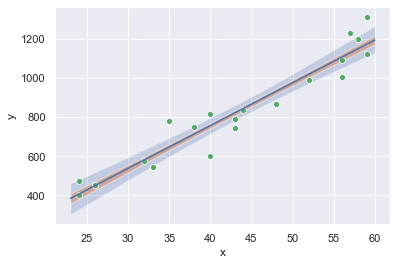

In [21]:
plot_with_quantile(y_n_base_df)

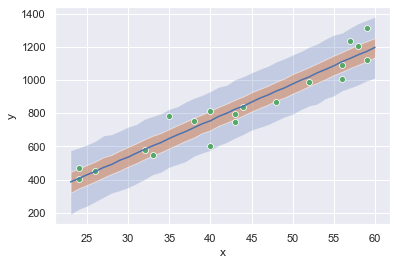

In [22]:
plot_with_quantile(y_n_pred_df)

## 4.4.12

In [23]:
!cat ../model/main-4.stan

data {
  int N;
  real x[N];
  real y[N];

  int N_new;
  real x_new[N_new];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

transformed parameters {
  real y_base[N];

  for (n in 1:N) {
    y_base[n] = a + b * x[n];
  }
}

model {
  for (n in 1:N) {
    y[n] ~ normal(y_base[n], sigma);
  }
}

generated quantities {
  real y_base_new[N_new];
  real y_new[N_new];

  for (n in 1:N_new) {
    y_base_new[n] = a + b * x_new[n];
    y_new[n] = normal_rng(y_base_new[n], sigma);
  }
}


In [24]:
model = pystan.StanModel(file='../model/main-4.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d063bcf25f33e1b6332b1295315b785 NOW.


In [25]:
data_salary_dict.update(N_new=len(x_new), x_new=x_new)

In [26]:
fit = model.sampling(data_salary_dict, seed=SEED, n_jobs=1)

In [27]:
fit

Inference for Stan model: anon_model_1d063bcf25f33e1b6332b1295315b785.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a              -118.5    2.04  73.98 -272.2 -167.1 -116.5 -68.39   25.0   1310    1.0
b               21.87    0.05   1.64  18.57  20.78  21.84  22.95  25.18   1317    1.0
sigma           84.98    0.41  15.53  60.79  73.86  83.05  93.57 120.78   1468    1.0
y_base[1]      406.45    0.98  37.28 331.72 382.01 406.46 431.94  478.4   1436    1.0
y_base[2]      406.45    0.98  37.28 331.72 382.01 406.46 431.94  478.4   1436    1.0
y_base[3]       450.2     0.9   34.5 380.59 427.91 450.08 473.65 516.32   1475    1.0
y_base[4]      581.43    0.65  26.85 527.26 564.31 581.68 599.44 632.57   1708    1.0
y_base[5]      603.31    0.61  25.73 551.23 587.13 603.66 620.58 652.28   1778    1.0
y_base[6]      647.05    0.53  23.66 

In [28]:
def plot_with_quantile(sample_array):
    y_base_new_quantile = np.percentile(sample_array, q=[2.5, 25, 50, 75, 97.5], axis=0)
    ax = sns.lineplot(x=x_new, y=y_base_new_quantile[2])
    ax.fill_between(x=x_new, y1=y_base_new_quantile[0], y2=y_base_new_quantile[4], alpha=0.25)
    ax.fill_between(x=x_new, y1=y_base_new_quantile[1], y2=y_base_new_quantile[3], alpha=0.5)
    sns.scatterplot(x='x', y='y', data=data_salary, ax=ax)

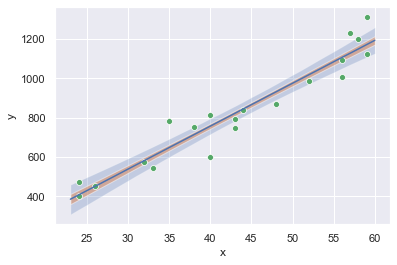

In [29]:
plot_with_quantile(fit.extract()['y_base_new'])

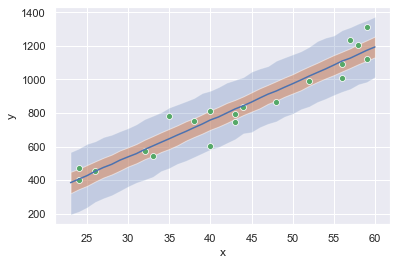

In [30]:
plot_with_quantile(fit.extract()['y_new'])